In [2]:
from Gian_experimental.NSGAIICustom.CustomOperators import NCSamplerFromPRef, NCMutationCounterproductive, \
    NCCrossoverTransition
from Gian_experimental.NSGAIICustom.NSGAIICustom import EvaluatedNCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple
from scipy.stats import ks_2samp, wasserstein_distance
from Gian_experimental.NSGAIICustom.testing_in_vitro.testing_operators_in_vitro import make_metrics_cached

#dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
# dir_250 = r"/Users/gian/PycharmProjects/PSSearch/data/retail_forecasting/250"

data_path = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"
import heapq
import itertools
import json
import random
from typing import Iterable, Optional, Iterator

import numpy as np

import utils
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import SPRef, OptimisedSPref
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities, get_transition_matrix
from PolishSystem.read_data import get_pRef_from_vectors
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
import heapq

def in_path(path):
    return os.path.join(data_path, path)



train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_path("train_many_hot_vectors_250_random.csv"),
                                   name_of_fitness_file=in_path("train_fitness_250_random.csv"),
                                   column_in_fitness_file=2)
test_pRef =  get_pRef_from_vectors(name_of_vectors_file=in_path("test_many_hot_vectors_250_random.csv"),
                                   name_of_fitness_file=in_path("test_fitness_250_random.csv"),
                                   column_in_fitness_file=2)

train_SPRef = OptimisedSPref.from_pRef(train_pRef)
test_SPRef = OptimisedSPref.from_pRef(test_pRef)

cluster_info_file_name = in_path(f"cluster_info_250_random.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

n = 250

def keep_ones_with_most_samples(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)

transition_matrix = get_transition_matrix(similarities)
custom_sampling = NCSamplerFromPRef.from_PRef(train_pRef)
custom_mutation = NCMutationCounterproductive(transition_matrix)
custom_crossover = NCCrossoverTransition(transition_matrix)

def atomicity(ps):
    if len(ps) < 2:
        return -1000
    else:
        linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
        return np.average(linkages)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)
traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)




In [21]:
from scipy.stats import mannwhitneyu
from Gian_experimental.NSGAIICustom.NSGAIICustom import NCSolution, NSGAIICustom



genome_threshold = 3

def get_metrics(ps: NCSolution) -> tuple[float]:
    # I will use sample size, variance and atomicity

    # for now, simplicity, mean fitness and atomicity
    #simplicity_score = len(ps)
    matching, non_matching = train_SPRef.partition(ps, threshold=genome_threshold)
    len_m, len_nm = len(matching), len(non_matching)
    weighted_variance_score = (np.var(matching) * len_m + np.var(non_matching) * len_nm) / (len_m + len_nm)
    #mean_fitness = np.average(matching) if len(matching) > 0 else -1000
    median_diff = np.median(matching) - np.median(non_matching)
    distance = wasserstein_distance(matching, non_matching) if min(len(matching), len(non_matching)) > 2 else 0
    #is_beneficial = np.average(matching) > np.average(non_matching)
    # if is_beneficial:
    #     distance *= -1
    #print(distance)
    atomicity_score = atomicity(ps)
    
    if len(matching) < 1000: # a constraint
        return 1000, 1000, 1000, 1000, 1000

    return (len(ps), -len(matching), -distance, -median_diff, -atomicity_score)

algorithm = NSGAIICustom(sampling=traditional_sampling,
                         mutation=traditional_mutation,
                         crossover=traditional_crossover,
                         probability_of_crossover=0.5,
                         eval_budget=6000,
                         pop_size=150,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_ones_with_most_samples
                         )

In [22]:
results  = algorithm.run()

NSGAIICustom -> Beginning of NC process
NSGAIICustom -> Used evals: 322
NSGAIICustom -> Used evals: 488
NSGAIICustom -> Used evals: 654
NSGAIICustom -> Used evals: 816
NSGAIICustom -> Used evals: 979
NSGAIICustom -> Used evals: 1140
NSGAIICustom -> Used evals: 1298
NSGAIICustom -> Used evals: 1455
NSGAIICustom -> Used evals: 1617
NSGAIICustom -> Used evals: 1781
NSGAIICustom -> Used evals: 1946
NSGAIICustom -> Used evals: 2103
NSGAIICustom -> Used evals: 2269
NSGAIICustom -> Used evals: 2431
NSGAIICustom -> Used evals: 2589
NSGAIICustom -> Used evals: 2754
NSGAIICustom -> Used evals: 2914
NSGAIICustom -> Used evals: 3072
NSGAIICustom -> Used evals: 3240
NSGAIICustom -> Used evals: 3400
NSGAIICustom -> Used evals: 3562
NSGAIICustom -> Used evals: 3721
NSGAIICustom -> Used evals: 3884
NSGAIICustom -> Used evals: 4041
NSGAIICustom -> Used evals: 4204
NSGAIICustom -> Used evals: 4363
NSGAIICustom -> Used evals: 4519
NSGAIICustom -> Used evals: 4683
NSGAIICustom -> Used evals: 4840
NSGAIICu

There are 149 results
(10, -7006, -1.7310734839471502, -1.4640073776245117, -0.20896676) 10
(11, -8935, -1.5692922791032577, -1.3228964805603027, -0.58966714) 11
(6, -1195, -3.607529840039022, -3.321119546890259, -0.24002406) 6
(6, -1508, -3.540044974165415, -3.2706313133239746, -0.07316378) 6
(11, -1842, -3.0548377482723286, -2.690016269683838, -0.6424132) 11
(6, -3260, -2.2130570383312933, -1.9748406410217285, -0.7601151) 6
(6, -3820, -2.316141281051923, -2.0872364044189453, -0.23862243) 6
(6, -1928, -2.996226446672906, -2.787829875946045, -0.7535742) 6
(6, -3386, -2.3567072680790275, -2.123528003692627, -0.21772833) 6
(6, -2837, -1.9789129506290455, -1.6519885063171387, -1.4830074) 6
(6, -4112, -2.145048235693398, -1.7845988273620605, -0.98523307) 6
(6, -3622, -1.7759998913773178, -1.4417428970336914, -1.4652226) 6
(6, -1190, -2.916301274264975, -2.5943331718444824, -1.727504) 6
(9, -3350, -2.7190507074914754, -2.396493434906006, -0.13253242) 9
(7, -2987, -2.8095608522994513, -2.554

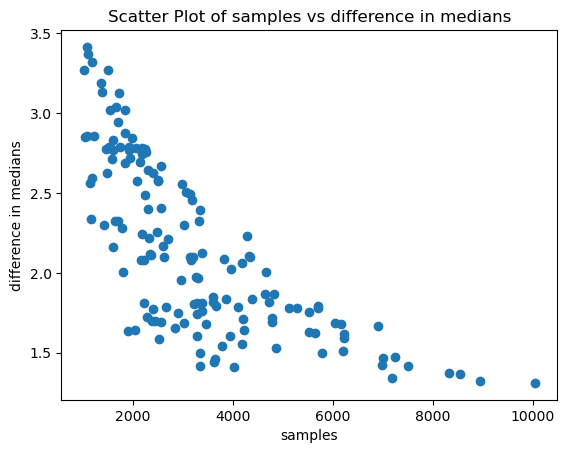

In [23]:
print(f"There are {len(results)} results")

for result in results:
    print(result.fitnesses, len(result.solution))
    
    
    
col_a = 1
col_b = 3
vals_a = [-ps.fitnesses[col_a] for ps in results if len(ps.solution) > 1]
vals_b = [-ps.fitnesses[col_b] for ps in results if len(ps.solution) > 1]

utils.simple_scatterplot(x_label="samples", y_label="difference in medians", xs=vals_a, ys=vals_b)

In [6]:


from matplotlib import pyplot as plt
from Gian_experimental.plotting_utils import display_side_by_side

def compare_histograms(
    data1,
    data2,
    bins=30,
    log_x=False,
    log_y=False,
    labels=("Data 1", "Data 2"),
    title="Histogram Comparison",
    figsize=(6, 4),
    ax=None,
    y_axis_frequency="absolute",  # "absolute" or "relative"
):
    """
    Creates a histogram comparison plot of two datasets on a given Axes or a new figure.

    Parameters:
        ...
        y_axis_frequency (str): "absolute" for counts, "relative" for percentages (0–100%).

    Returns:
        matplotlib.figure.Figure or None
    """
    data1 = np.array(data1)
    data2 = np.array(data2)

    if log_x:
        data1 = data1[data1 > 0]
        data2 = data2[data2 > 0]
        combined = np.concatenate([data1, data2])
        min_val = combined.min()
        max_val = combined.max()
        bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    density = y_axis_frequency == "relative"

    ax.hist(data1, bins=bins, alpha=0.5, label=labels[0], edgecolor='black', density=density)
    ax.hist(data2, bins=bins, alpha=0.5, label=labels[1], edgecolor='black', density=density)

    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

    ax.set_xlabel("Value")
    ax.set_ylabel("Percentage" if density else "Frequency")

    if density:
        # Convert y-axis to percentage
        ticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])

    ax.set_title(title)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    return fig

def display_side_by_side(histogram_args_list, figsize_per_plot=(5, 5)):
    """
    Displays multiple histograms side-by-side using `compare_histograms`.

    Parameters:
        histogram_args_list (list[dict]): Each dict contains args for `compare_histograms`.
        figsize_per_plot (tuple): Size per individual plot; used to scale total figure.
    """
    num = len(histogram_args_list)
    total_figsize = (figsize_per_plot[0] * num, figsize_per_plot[1])
    fig, axs = plt.subplots(1, num, figsize=total_figsize)

    if num == 1:
        axs = [axs]  # Ensure it's iterable

    for args, ax in zip(histogram_args_list, axs):
        compare_histograms(ax=ax, **args)

    plt.tight_layout()
    plt.show()


def get_textual_description_of_distribution(values):
    return (f"n = {len(values)},\n"
              f"average = {np.average(values):.2f}, median = {np.median(values):.2f}\n"
              f"min = {np.min(values):.2f}, max = {np.max(values):.2f},\n")

def make_ps_into_explanation(ps, genome_threshold, test_SPref: SPRef):
    print(f"If you match this list of {len(ps)}, with threshold {genome_threshold}:")
    print(ps)
    

    match_fitnesses, match_non_fitnesses = test_SPref.partition(ps, genome_threshold)
    
    if len(match_fitnesses) < 100 or len(match_non_fitnesses) < 100:
        print(f"There are not enough matches!!!  {len(match_fitnesses)}, {len(match_non_fitnesses)}")
        return
    all_fitnesses = test_SPref.fitnesses
    distance = wasserstein_distance(match_fitnesses, match_non_fitnesses)
    
    print(f"The Wasserstein distance is {distance}")
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_fitnesses)))
    print("Distribution of non match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_non_fitnesses)))
    
    display_side_by_side([
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Fitnesses of matches vs non-matches",
                "labels": ("Matches", "Non matches"),
                "y_axis_frequency": "relative"
            },
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Absolute view",
                "labels": ("Matches", "Non Matches"),
                "y_axis_frequency": "absolute"
            }
        ])

149 are satisfactory out of 149
The metrics were (11, -10036, -1.5521200199283816, -1.3110041618347168, 0.044366296)
If you match this list of 11, with threshold 3:
{1, 201, 171, 13, 80, 242, 114, 19, 181, 55, 188}
The Wasserstein distance is 1.5414923373716045
Distribution of match fitness
	n = 4364,
	average = 8.77, median = 8.39
	min = 1.45, max = 38.68,
	
Distribution of non match fitness
	n = 11474,
	average = 7.23, median = 7.15
	min = 0.07, max = 25.69,
	


C:\Users\gac8\AppData\Local\Temp\ipykernel_15308\892386325.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


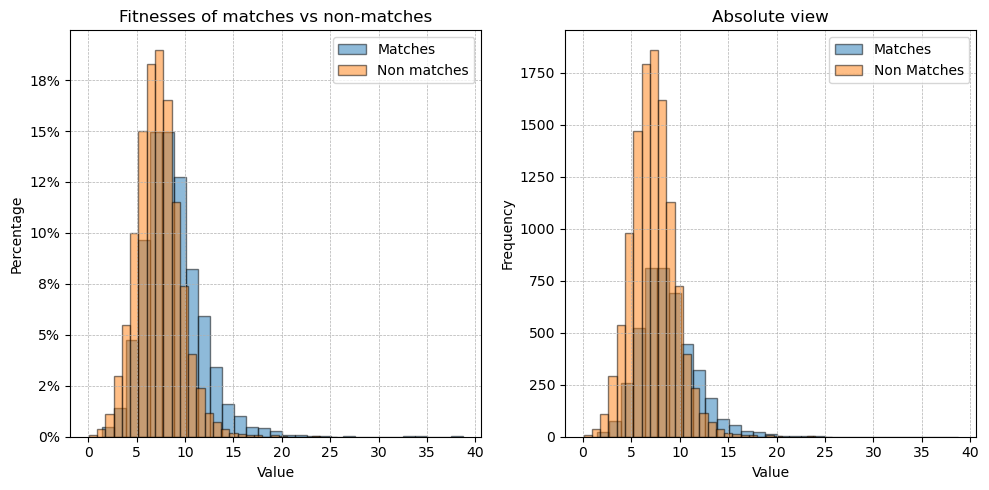

The metrics were (12, -7244, -1.740187150816069, -1.4759221076965332, -0.37187123)
If you match this list of 12, with threshold 3:
{226, 223, 70, 42, 235, 142, 80, 114, 55, 184, 188, 127}
The Wasserstein distance is 1.7577329137680446
Distribution of match fitness
	n = 3090,
	average = 9.07, median = 8.63
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 12748,
	average = 7.31, median = 7.23
	min = 0.07, max = 23.66,
	


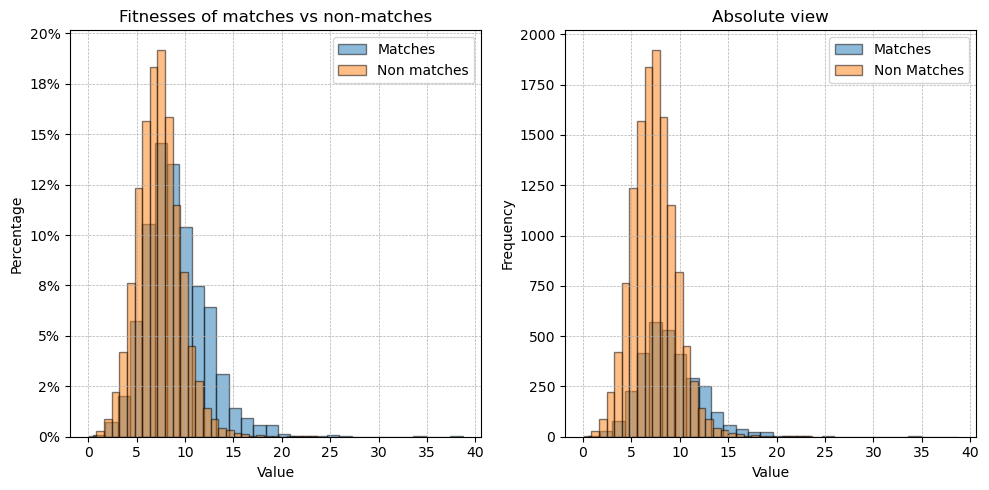

The metrics were (8, -6226, -1.843558400182964, -1.5910019874572754, -0.68970346)
If you match this list of 8, with threshold 3:
{188, 18, 100, 116, 204, 157, 142, 63}
The Wasserstein distance is 1.935538423949846
Distribution of match fitness
	n = 2791,
	average = 9.25, median = 8.88
	min = 0.49, max = 38.68,
	
Distribution of non match fitness
	n = 13047,
	average = 7.32, median = 7.23
	min = 0.07, max = 25.69,
	


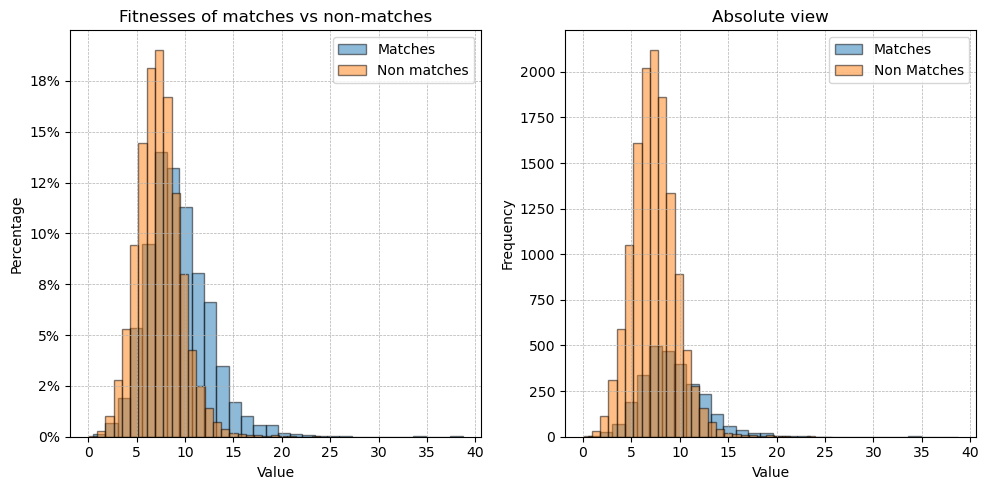

The metrics were (7, -5778, -1.751786086893539, -1.4992027282714844, -0.72022367)
If you match this list of 7, with threshold 3:
{80, 177, 81, 224, 55, 235, 188}
The Wasserstein distance is 1.7249321383435512
Distribution of match fitness
	n = 2453,
	average = 9.12, median = 8.66
	min = 1.94, max = 38.68,
	
Distribution of non match fitness
	n = 13385,
	average = 7.39, median = 7.27
	min = 0.07, max = 25.69,
	


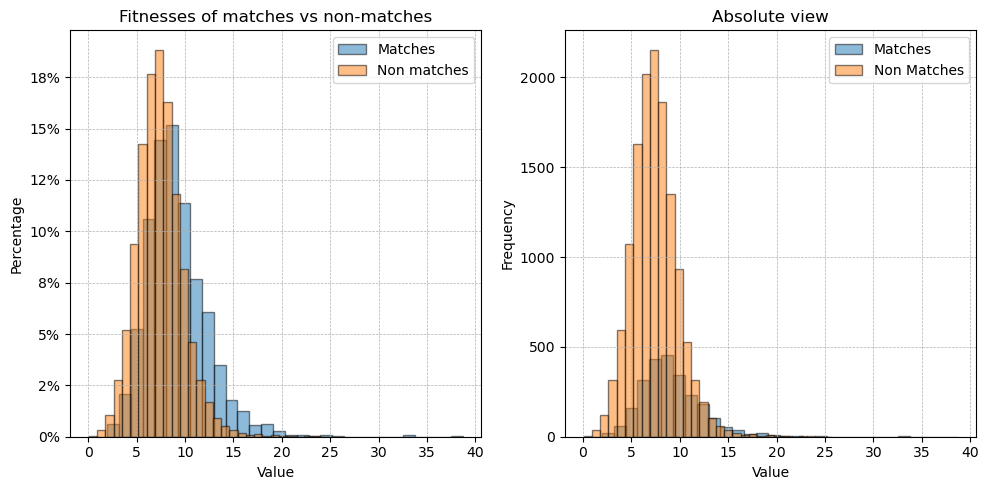

The metrics were (7, -5524, -1.8869728744449432, -1.629410743713379, -0.54471904)
If you match this list of 7, with threshold 3:
{80, 177, 50, 204, 55, 235, 188}
The Wasserstein distance is 1.906953769016738
Distribution of match fitness
	n = 2326,
	average = 9.28, median = 8.80
	min = 1.17, max = 38.68,
	
Distribution of non match fitness
	n = 13512,
	average = 7.38, median = 7.27
	min = 0.07, max = 25.69,
	


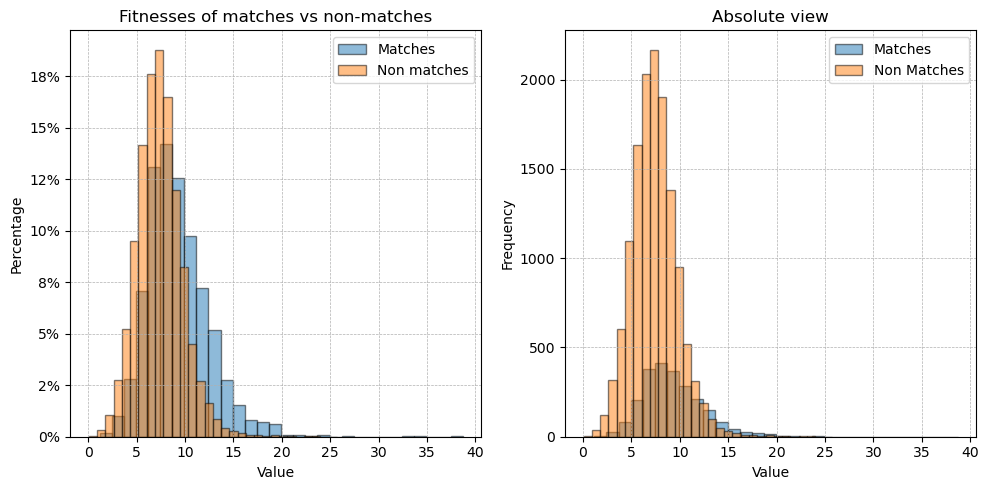

The metrics were (7, -4781, -2.0549276416024598, -1.719627857208252, -0.8933052)
If you match this list of 7, with threshold 3:
{80, 146, 134, 55, 167, 235, 188}
The Wasserstein distance is 2.04488269238922
Distribution of match fitness
	n = 2004,
	average = 9.44, median = 9.01
	min = 1.17, max = 38.68,
	
Distribution of non match fitness
	n = 13834,
	average = 7.40, median = 7.28
	min = 0.07, max = 24.74,
	


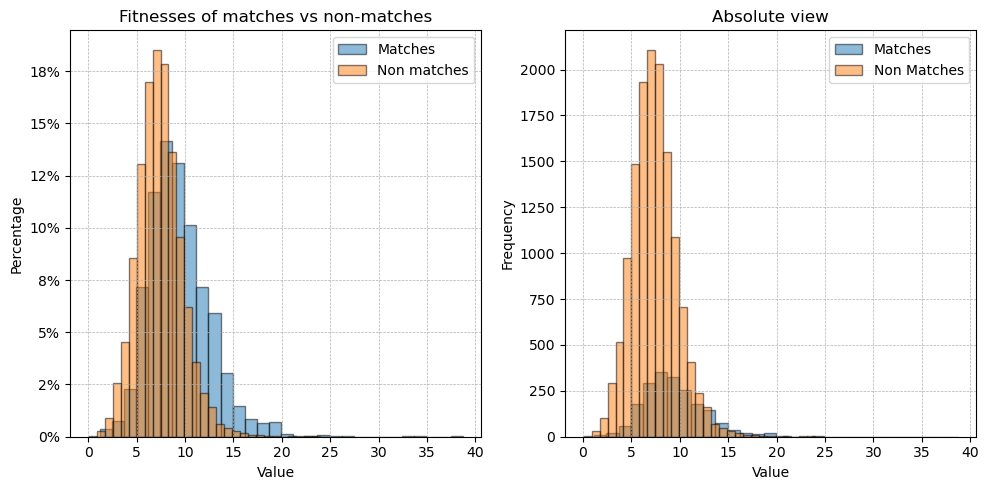

The metrics were (6, -4383, -2.115786352654505, -1.836761236190796, -0.10103771)
If you match this list of 6, with threshold 3:
{100, 116, 139, 188, 157, 142}
The Wasserstein distance is 2.190741773849202
Distribution of match fitness
	n = 1929,
	average = 9.58, median = 9.23
	min = 1.57, max = 38.68,
	
Distribution of non match fitness
	n = 13909,
	average = 7.39, median = 7.27
	min = 0.07, max = 25.69,
	


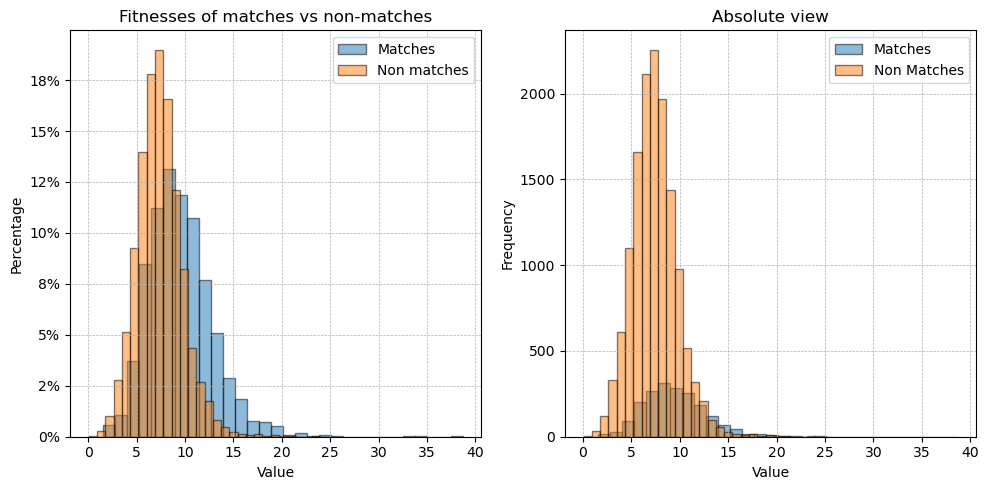

The metrics were (12, -4212, -2.075920762067926, -1.7120838165283203, -0.973383)
If you match this list of 12, with threshold 3:
{248, 4, 37, 166, 235, 79, 80, 114, 21, 55, 56, 26}
The Wasserstein distance is 2.226935143783906
Distribution of match fitness
	n = 1808,
	average = 9.63, median = 9.11
	min = 2.39, max = 38.68,
	
Distribution of non match fitness
	n = 14030,
	average = 7.40, median = 7.29
	min = 0.07, max = 25.69,
	


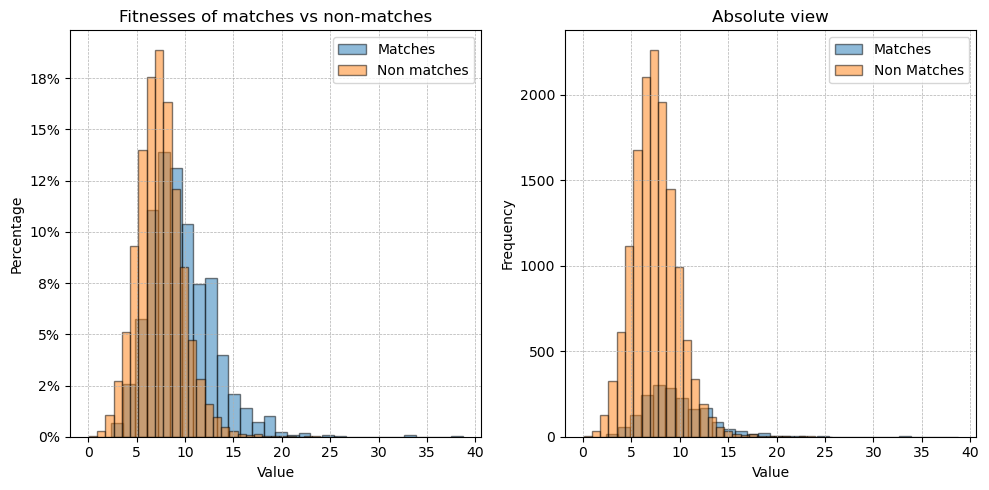

The metrics were (12, -3969, -2.2409413368519107, -2.0225229263305664, -0.5847392)
If you match this list of 12, with threshold 3:
{3, 163, 195, 236, 127, 80, 145, 114, 216, 186, 188, 191}
The Wasserstein distance is 2.2763445069485595
Distribution of match fitness
	n = 1695,
	average = 9.69, median = 9.15
	min = 2.19, max = 38.68,
	
Distribution of non match fitness
	n = 14143,
	average = 7.41, median = 7.28
	min = 0.07, max = 25.69,
	


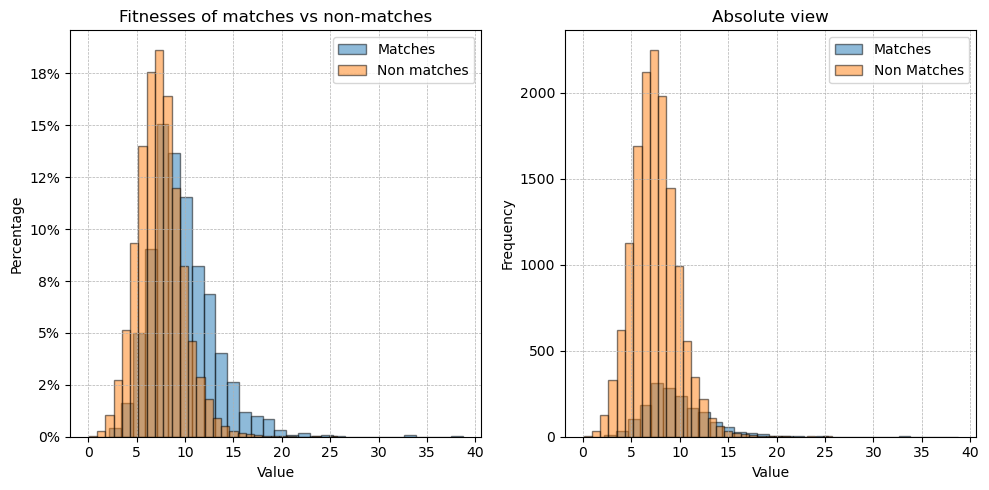

The metrics were (7, -3664, -2.1149558584857697, -1.7942919731140137, -0.88357216)
If you match this list of 7, with threshold 3:
{80, 99, 181, 55, 56, 235, 188}
The Wasserstein distance is 2.1529146069280714
Distribution of match fitness
	n = 1583,
	average = 9.60, median = 9.04
	min = 2.39, max = 38.68,
	
Distribution of non match fitness
	n = 14255,
	average = 7.44, median = 7.31
	min = 0.07, max = 33.66,
	


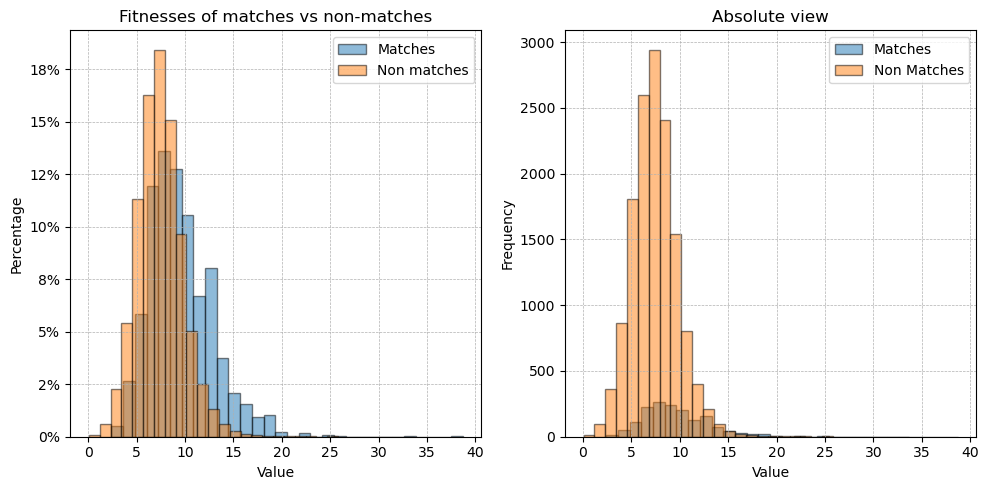

The metrics were (5, -3461, -2.0433365503156713, -1.6822526454925537, -0.68981254)
If you match this list of 5, with threshold 3:
{196, 235, 80, 55, 188}
The Wasserstein distance is 2.03210664708096
Distribution of match fitness
	n = 1496,
	average = 9.50, median = 8.90
	min = 1.16, max = 38.68,
	
Distribution of non match fitness
	n = 14342,
	average = 7.47, median = 7.33
	min = 0.07, max = 33.66,
	


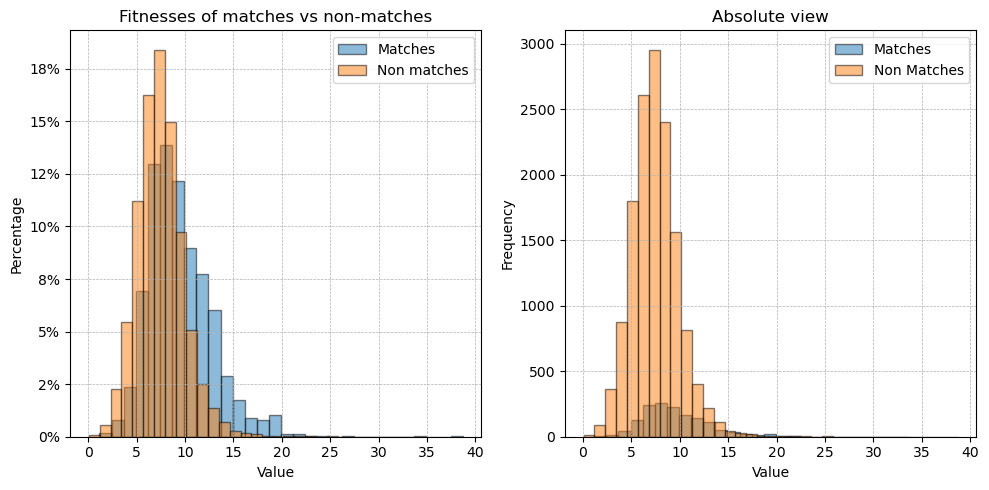

The metrics were (9, -3350, -2.7190507074914754, -2.396493434906006, -0.13253242)
If you match this list of 9, with threshold 3:
{193, 142, 94, 225, 100, 164, 116, 181, 245}
The Wasserstein distance is 2.7632762580069024
Distribution of match fitness
	n = 1497,
	average = 10.16, median = 9.82
	min = 0.78, max = 38.68,
	
Distribution of non match fitness
	n = 14341,
	average = 7.40, median = 7.28
	min = 0.07, max = 25.69,
	


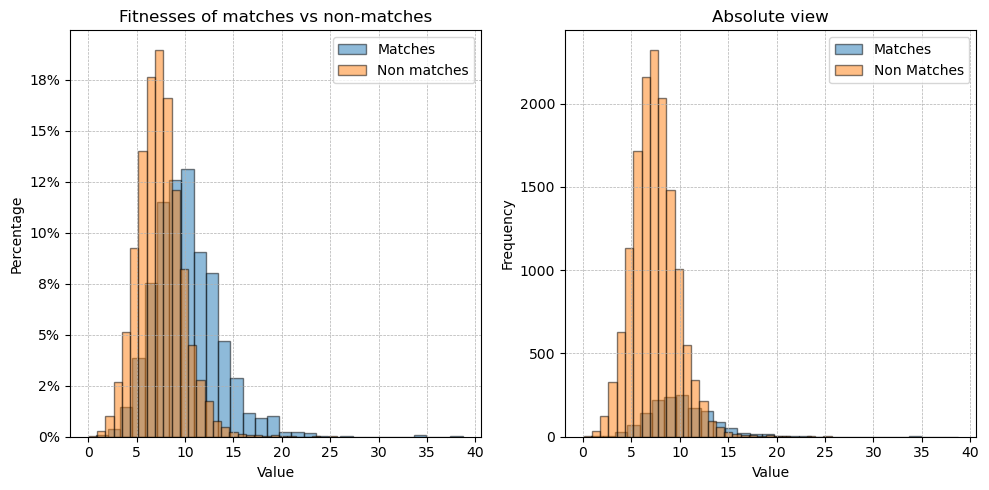

The metrics were (6, -3286, -1.9680934126840641, -1.6047873497009277, -1.2195429)
If you match this list of 6, with threshold 3:
{80, 188, 55, 235, 108, 63}
The Wasserstein distance is 1.9842257202143405
Distribution of match fitness
	n = 1425,
	average = 9.46, median = 9.00
	min = 2.12, max = 38.68,
	
Distribution of non match fitness
	n = 14413,
	average = 7.48, median = 7.33
	min = 0.07, max = 33.66,
	


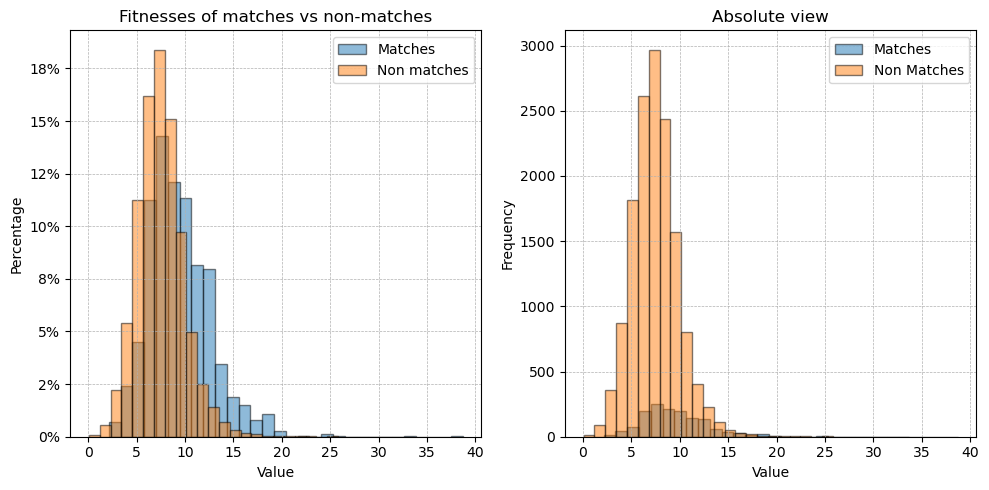

The metrics were (8, -3192, -2.738175510042383, -2.4591360092163086, -0.80096895)
If you match this list of 8, with threshold 3:
{16, 164, 100, 116, 181, 27, 142, 31}
The Wasserstein distance is 2.634312141767051
Distribution of match fitness
	n = 1409,
	average = 10.06, median = 9.66
	min = 1.16, max = 38.68,
	
Distribution of non match fitness
	n = 14429,
	average = 7.42, median = 7.30
	min = 0.07, max = 25.69,
	


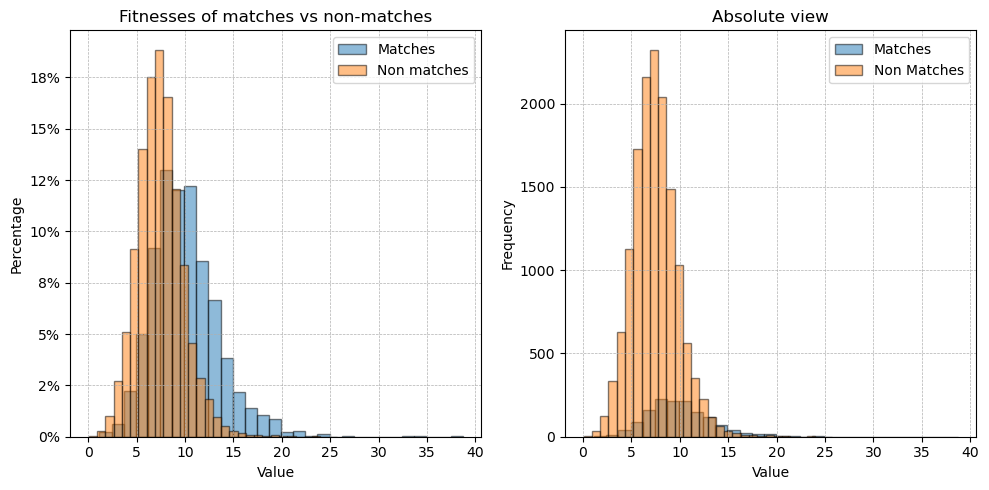

The metrics were (6, -3036, -2.558134643409087, -2.2990126609802246, 0.094428256)
If you match this list of 6, with threshold 3:
{83, 196, 244, 245, 171, 173}
The Wasserstein distance is 2.579935546389428
Distribution of match fitness
	n = 1298,
	average = 10.03, median = 9.60
	min = 1.82, max = 38.68,
	
Distribution of non match fitness
	n = 14540,
	average = 7.45, median = 7.31
	min = 0.07, max = 25.69,
	


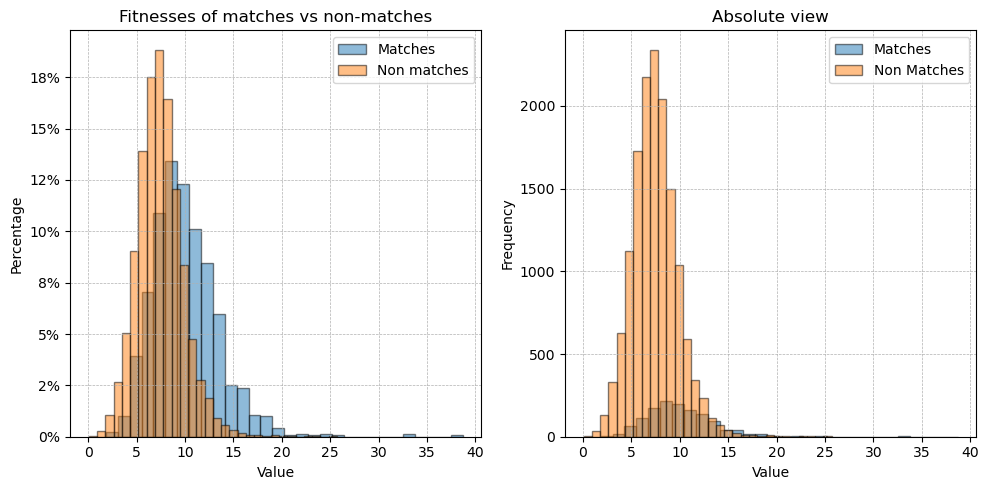

The metrics were (6, -2837, -1.9789129506290455, -1.6519885063171387, -1.4830074)
If you match this list of 6, with threshold 3:
{80, 188, 226, 55, 235, 108}
The Wasserstein distance is 1.893512631968322
Distribution of match fitness
	n = 1242,
	average = 9.40, median = 8.87
	min = 2.13, max = 38.68,
	
Distribution of non match fitness
	n = 14596,
	average = 7.51, median = 7.35
	min = 0.07, max = 33.66,
	


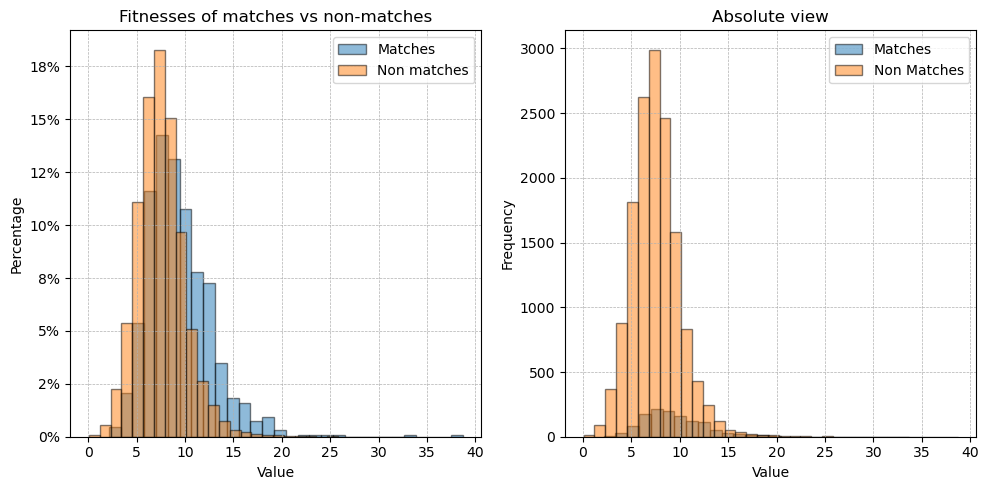

The metrics were (7, -2573, -2.9352943891160805, -2.667891263961792, -0.19409136)
If you match this list of 7, with threshold 3:
{80, 114, 100, 212, 181, 157, 142}
The Wasserstein distance is 2.956630233104825
Distribution of match fitness
	n = 1127,
	average = 10.40, median = 10.08
	min = 2.02, max = 38.68,
	
Distribution of non match fitness
	n = 14711,
	average = 7.45, median = 7.32
	min = 0.07, max = 25.69,
	


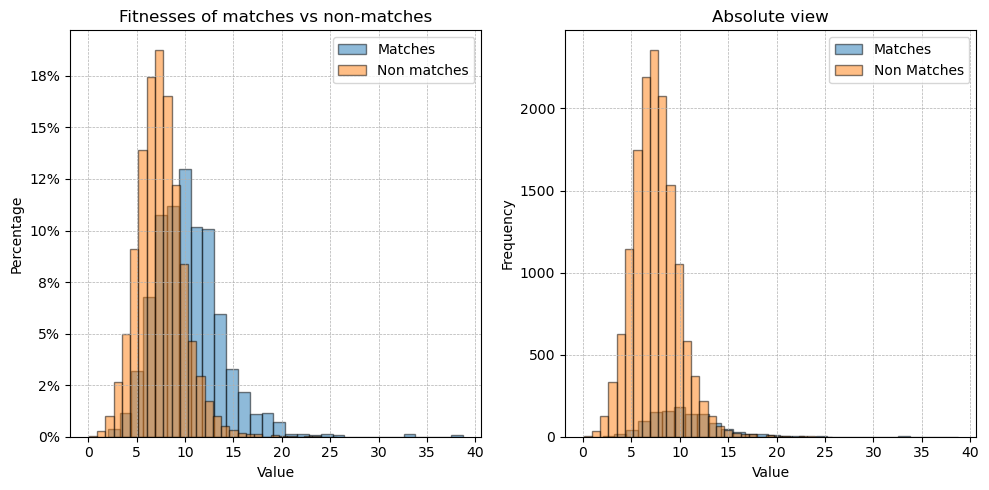

The metrics were (6, -2509, -2.8000112753242243, -2.572491407394409, 0.22869234)
If you match this list of 6, with threshold 3:
{83, 196, 244, 245, 139, 61}
The Wasserstein distance is 3.037880800712807
Distribution of match fitness
	n = 1065,
	average = 10.49, median = 10.09
	min = 3.39, max = 38.68,
	
Distribution of non match fitness
	n = 14773,
	average = 7.45, median = 7.31
	min = 0.07, max = 33.66,
	


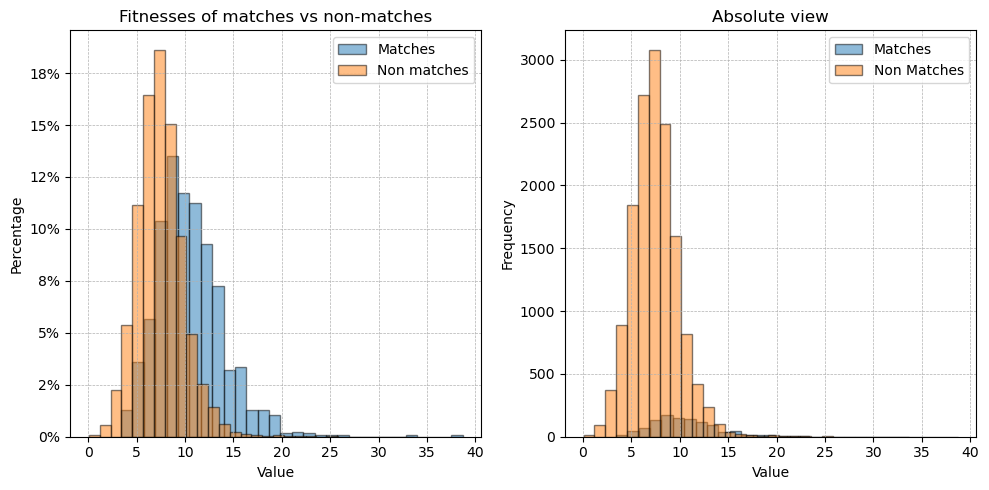

The metrics were (5, -2380, -2.0666055675029007, -1.6996002197265625, -0.7223412)
If you match this list of 5, with threshold 3:
{80, 146, 55, 235, 188}
The Wasserstein distance is 2.035935582110806
Distribution of match fitness
	n = 1014,
	average = 9.56, median = 8.99
	min = 2.39, max = 38.68,
	
Distribution of non match fitness
	n = 14824,
	average = 7.53, median = 7.36
	min = 0.07, max = 33.66,
	


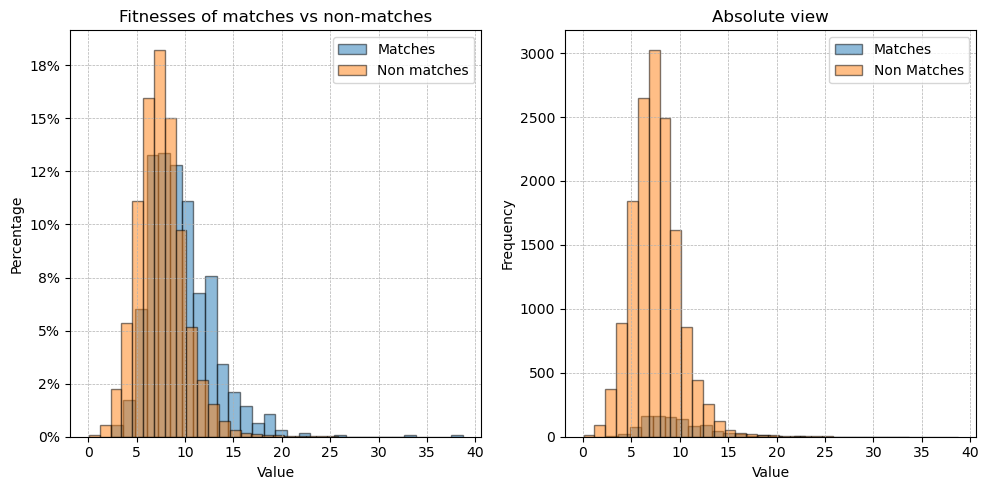

The metrics were (6, -2298, -2.6129501570312073, -2.4010162353515625, -0.38806704)
If you match this list of 6, with threshold 3:
{225, 149, 55, 235, 188, 239}
The Wasserstein distance is 2.5140640731822623
Distribution of match fitness
	n = 983,
	average = 10.02, median = 9.59
	min = 1.61, max = 38.68,
	
Distribution of non match fitness
	n = 14855,
	average = 7.50, median = 7.34
	min = 0.07, max = 33.66,
	


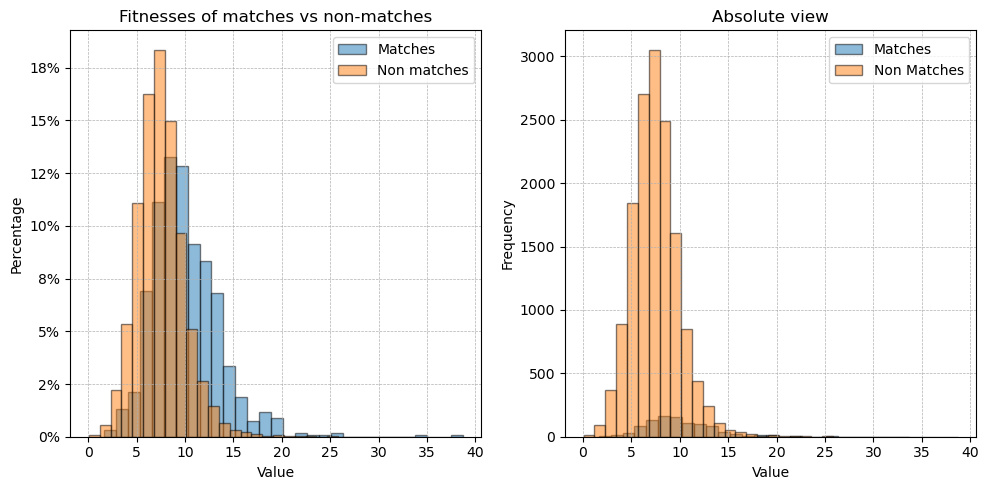

The metrics were (5, -2226, -2.1349489524730876, -1.8133673667907715, -0.5926058)
If you match this list of 5, with threshold 3:
{235, 239, 80, 55, 188}
The Wasserstein distance is 2.050245425395852
Distribution of match fitness
	n = 978,
	average = 9.58, median = 9.02
	min = 2.39, max = 38.68,
	
Distribution of non match fitness
	n = 14860,
	average = 7.53, median = 7.36
	min = 0.07, max = 33.66,
	


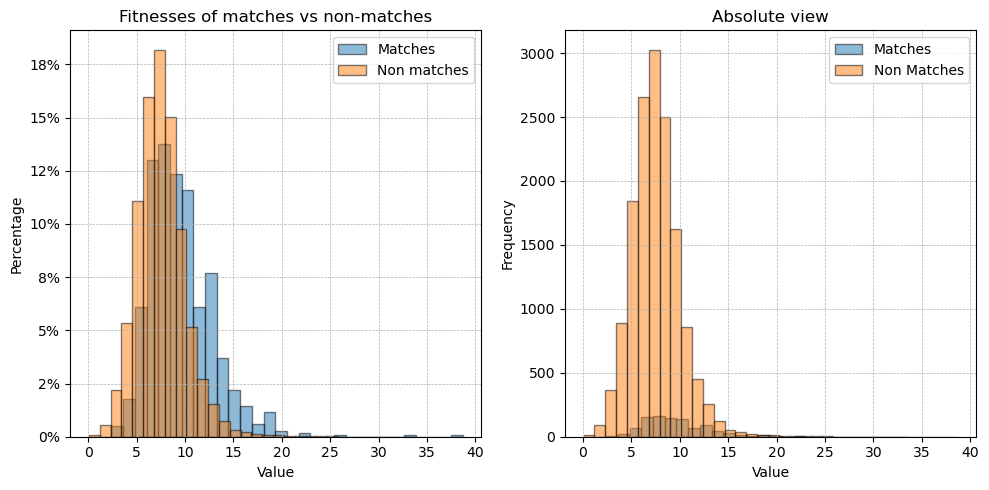

The metrics were (6, -2176, -2.3639149218998328, -2.0831966400146484, -2.168413)
If you match this list of 6, with threshold 3:
{114, 4, 167, 137, 155, 188}
The Wasserstein distance is 2.703183032708691
Distribution of match fitness
	n = 975,
	average = 10.19, median = 9.79
	min = 2.77, max = 38.68,
	
Distribution of non match fitness
	n = 14863,
	average = 7.49, median = 7.34
	min = 0.07, max = 33.75,
	


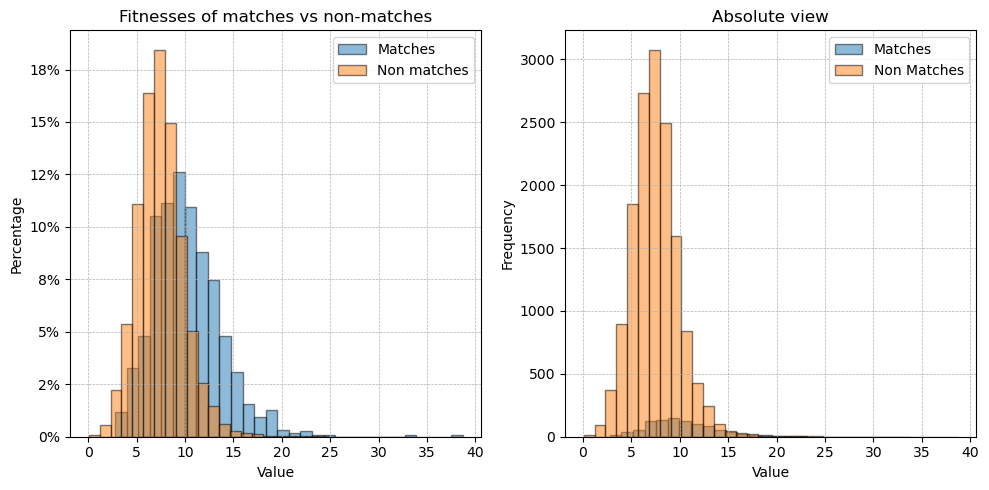

The metrics were (6, -1983, -3.0959632245697715, -2.843672513961792, 0.087447055)
If you match this list of 6, with threshold 3:
{83, 196, 244, 245, 155, 173}
The Wasserstein distance is 3.202964866482838
Distribution of match fitness
	n = 864,
	average = 10.69, median = 10.21
	min = 3.44, max = 38.68,
	
Distribution of non match fitness
	n = 14974,
	average = 7.48, median = 7.33
	min = 0.07, max = 33.66,
	


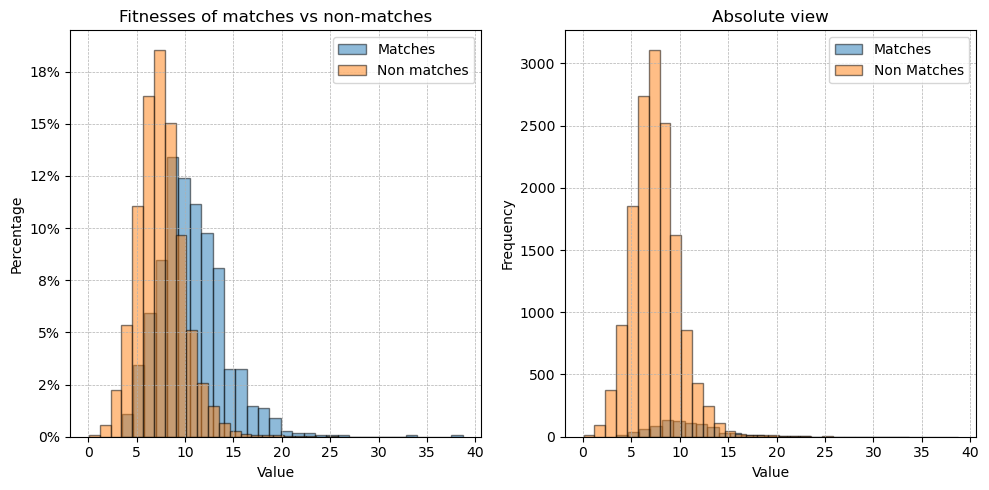

The metrics were (6, -1857, -3.2738837835781185, -3.0173959732055664, -0.30116403)
If you match this list of 6, with threshold 3:
{100, 116, 181, 157, 142, 63}
The Wasserstein distance is 3.314898545537425
Distribution of match fitness
	n = 851,
	average = 10.79, median = 10.38
	min = 0.70, max = 38.68,
	
Distribution of non match fitness
	n = 14987,
	average = 7.48, median = 7.34
	min = 0.07, max = 25.69,
	


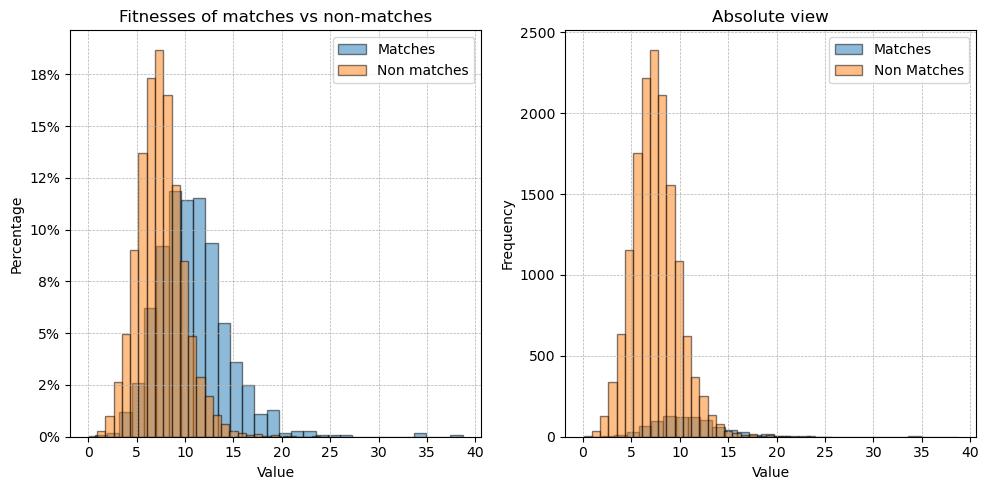

The metrics were (5, -1740, -3.0203391490370533, -2.7910547256469727, -0.31143004)
If you match this list of 5, with threshold 3:
{100, 212, 181, 157, 142}
The Wasserstein distance is 3.0852972585123104
Distribution of match fitness
	n = 764,
	average = 10.59, median = 10.25
	min = 2.02, max = 38.68,
	
Distribution of non match fitness
	n = 15074,
	average = 7.51, median = 7.35
	min = 0.07, max = 25.69,
	


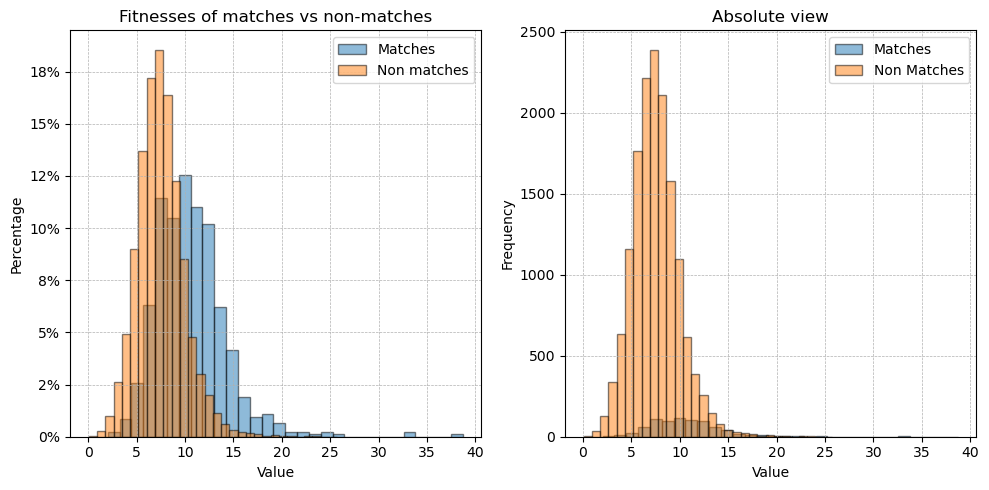

The metrics were (5, -1645, -2.7444146516374817, -2.324263572692871, -0.49734536)
If you match this list of 5, with threshold 3:
{4, 235, 80, 114, 188}
The Wasserstein distance is 2.655590381454233
Distribution of match fitness
	n = 739,
	average = 10.19, median = 9.76
	min = 2.39, max = 38.68,
	
Distribution of non match fitness
	n = 15099,
	average = 7.53, median = 7.37
	min = 0.07, max = 33.75,
	


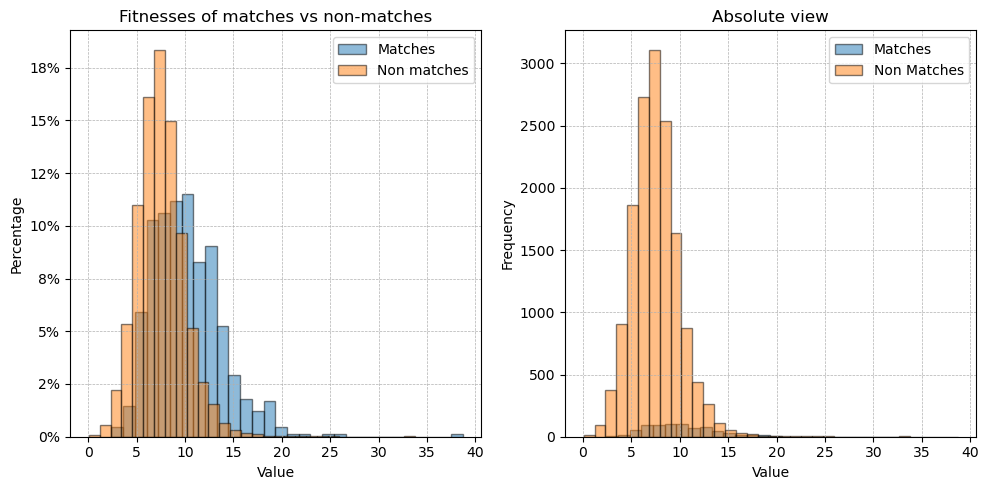

The metrics were (5, -1556, -3.219642480635004, -3.0195083618164062, 0.33115706)
If you match this list of 5, with threshold 3:
{196, 83, 244, 245, 61}
The Wasserstein distance is 3.411466082358385
Distribution of match fitness
	n = 663,
	average = 10.93, median = 10.39
	min = 3.44, max = 38.68,
	
Distribution of non match fitness
	n = 15175,
	average = 7.51, median = 7.36
	min = 0.07, max = 33.66,
	


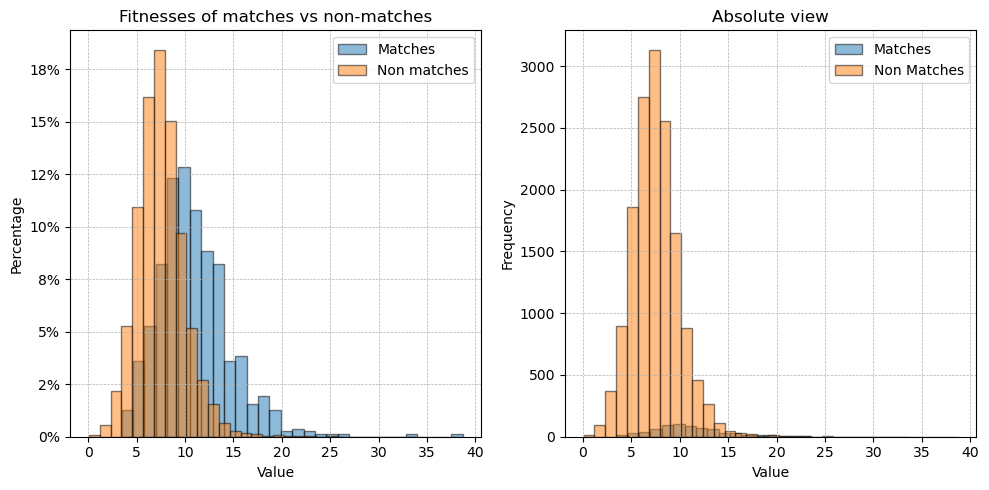

The metrics were (7, -1475, -3.132479166195516, -2.778374671936035, -0.8107345)
If you match this list of 7, with threshold 3:
{80, 4, 55, 56, 235, 172, 44}
The Wasserstein distance is 3.2326325738326602
Distribution of match fitness
	n = 632,
	average = 10.76, median = 10.35
	min = 3.64, max = 38.68,
	
Distribution of non match fitness
	n = 15206,
	average = 7.53, median = 7.37
	min = 0.07, max = 33.66,
	


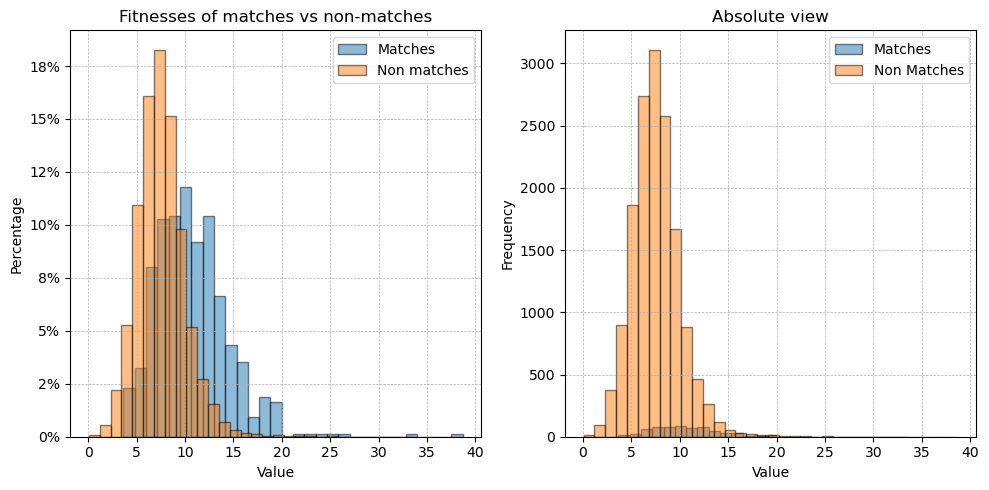

The metrics were (6, -1195, -3.607529840039022, -3.321119546890259, -0.24002406)
If you match this list of 6, with threshold 3:
{164, 100, 116, 181, 187, 142}
The Wasserstein distance is 3.6262446072210053
Distribution of match fitness
	n = 529,
	average = 11.16, median = 10.69
	min = 2.61, max = 38.68,
	
Distribution of non match fitness
	n = 15309,
	average = 7.54, median = 7.37
	min = 0.07, max = 25.69,
	


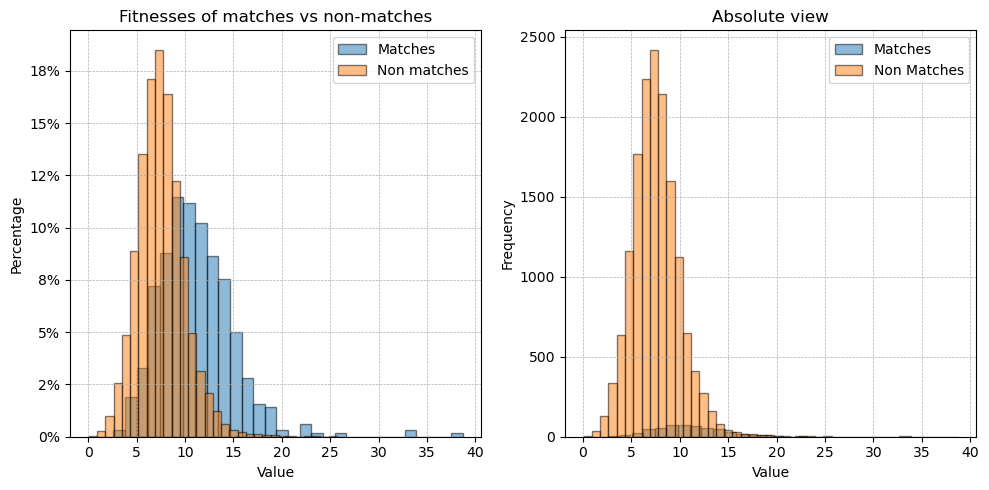

The metrics were (5, -1094, -3.6872239216225386, -3.4148178100585938, -0.13925828)
If you match this list of 5, with threshold 3:
{100, 116, 181, 164, 142}
The Wasserstein distance is 3.689889508188374
Distribution of match fitness
	n = 487,
	average = 11.23, median = 10.75
	min = 2.61, max = 38.68,
	
Distribution of non match fitness
	n = 15351,
	average = 7.54, median = 7.38
	min = 0.07, max = 25.69,
	


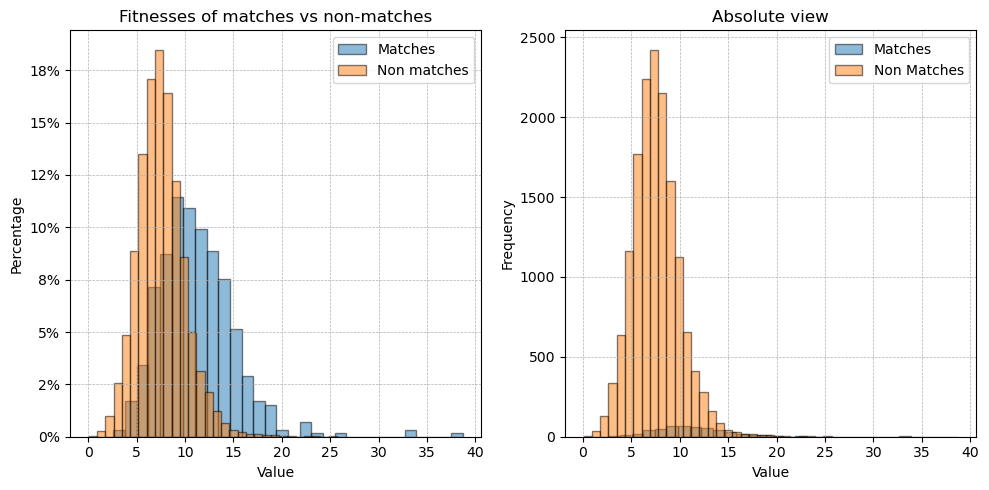

In [26]:
threshold_proportion_train = 0.1  # at least 10 %
threshold_quantity_train = round(len(train_SPRef.fitnesses) * threshold_proportion_train) 
def has_enough_matches_in_train(result_of_NSGAII: EvaluatedNCSolution):
    #print(f"Checking {result_of_NSGAII}")
    match_fitnesses, match_non_fitnesses = train_SPRef.partition(result_of_NSGAII.solution, genome_threshold)
    proportion = len(match_fitnesses) / len(train_SPRef.fitnesses)
    #print(proportion)
    return True

satisfactory_pss = list(filter(has_enough_matches_in_train, results))

print(f"{len(satisfactory_pss)} are satisfactory out of {len(results)}")
        

for result in sorted(satisfactory_pss, key=lambda x: x.fitnesses[1], reverse=False)[::5]:
    print(f"The metrics were {result.fitnesses}")
    make_ps_into_explanation(result.solution, genome_threshold=genome_threshold, test_SPref=test_SPRef)

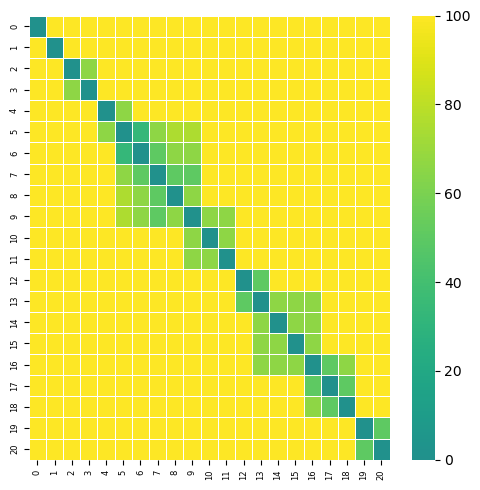

In [8]:


from initial_testing.understand_files.rearrange_linkage_table import clean_table
from collections import defaultdict



def distance_function(a: set, b: set):
    return 100 * len(set.union(a, b) - a.intersection(b)) / len(set.union(a, b))
    

to_show = satisfactory_pss
quantity = len(to_show)
distance_matrix = np.zeros(shape=(quantity, quantity), dtype=int)
for i, j in itertools.combinations(range(quantity), r=2):
    distance_matrix[i, j] = distance_function(to_show[i].solution, to_show[j].solution)


distance_matrix += distance_matrix.T

utils.show_matrix_with_colours(clean_table(distance_matrix), fig_size=(5, 5))


# the table makes me think that #2 is different from everything else, so let's consider 0 and 2






    

In [9]:
matches_by_any, non_matches_by_any = ([], [])


SPRef_to_get_from = test_SPRef
pss_to_consider =satisfactory_pss
for session, fitness in zip(SPRef_to_get_from.sessions, SPRef_to_get_from.fitnesses):
    def matches_pattern(run_result):
        return len(run_result.solution.intersection(session)) >=genome_threshold
    if any(map(matches_pattern, pss_to_consider)):
        matches_by_any.append(fitness)
    else:
        non_matches_by_any.append(fitness)


display_side_by_side([
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "relative"
    },
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "absolute"
    },
])
            
    

TypeError: '>=' not supported between instances of 'int' and 'NoneType'